# AnnoTree-diamond-jupyter

##### What's Diamond
DIAMOND is a sequence aligner for protein and translated DNA searches designed for high-performance analysis of big sequence data. 

##### Why AnnoTree?
The NCBI-nr database is not explicitly designed for microbiome analysis, and its increasing size makes it unwieldy and computationally expensive for this purpose. The AnnoTree protein database is only one-quarter the size of the entire NCBI-nr database and is explicitly designed for metagenomic analysis, so alignment-based pipelines should support it.
https://journals.asm.org/doi/10.1128/msystems.01408-21

##### Which input files?

1. Trinity fasta file
2. Abundance-filtered coun table

##### Which preprocessing?
We follow the same preprocessing as in CoMW. We filter by e-value, get the most significant contig, and the aggregate rows (we sum up all rows corresponding to different Trinity genes aligned to the same protein).  
https://academic.oup.com/gigascience/article/8/8/giz096/5541629?login=true

##### Which database files?

We are using three different files (all of them in /Databases/AnnoTree_mRNA/)
'annotree.dmnd' is a diamond database (a particular format obtained from a fasta file)
'megan-mapping-annotree-June-2021.db' is an SQLite file with mappings from the name of each protein to annotations. 
'ko00001.json' is a JSON file with the BRITE hierarchy annotation  for KEGG

## Analysis
First, check dependencies. Safe to ignore. If any error, you can create a new conda enviroment with:

In [1]:
%%bash
diamond --version
python -c "import pandas; print(pandas.__version__)"
python -c "import matplotlib; print(matplotlib.__version__)"
python -c "import ete3; print(ete3.__version__)"
bash --version | head -n 1

diamond version 2.1.8


2.1.1
3.8.0
3.1.3
GNU bash, version 4.4.20(1)-release (x86_64-pc-linux-gnu)


In [2]:
import os
import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from contextlib import closing
from enum import Enum

### Input files (edit this chunk)
Edit this chunk to match your input files

In [3]:
trinity_file = snakemake.input.trinity
count_table = snakemake.input.count_table

In [4]:
## Sanity check: trinity and count table exit
assert os.path.exists(trinity_file), 'Trinity file does not exist'
assert os.path.exists(count_table), 'Count table does not exist'

### Output files (edit this chunk)
Edit this chunk to match your desired output files

In [5]:
outfile_matches = snakemake.output.diamond

### Database files
Don't edit this chunk

In [ ]:
annotree_db = snakemake.input.database
mapping_db =  snakemake.input.mapping
brite_json = snakemake.input.brite
threads = snakemake.threads
assert os.path.exists(f"{annotree_db}"), 'Annotree database does not exist'
assert os.path.exists(mapping_db), 'Mapping database does not exist'
assert os.path.exists(brite_json), 'Brite json file does not exist'
assert threads > 0, 'Threads must be greater than 0'

##### Run Diamond
When using Diamond, you should consider which sensitivity mode do you want to use. Default mode is designed for finding hits of >60% identity and it should take less than one hour to run. You might consider increase the sensitivity by editing the chunk below. 

In [7]:
%%bash -s "$annotree_db" "$trinity_file" "$outfile_matches" "$threads"
if [ ! -f $3 ]; then
mkdir -p $(dirname $3)
diamond blastx -p $4 -d $1 -q $2 -o $3
fi
head $3


TRINITY_DN226500_c0_g1_i1	NZ_LT934425_1_2685__RS_GCF_900232105_1	100	70	0	0	2	211	540	609	3.90e-42	154
TRINITY_DN226500_c0_g1_i1	NZ_LT934425_1_3564__RS_GCF_900232105_1	100	70	0	0	2	211	540	609	3.90e-42	154
TRINITY_DN226500_c0_g1_i1	MHZD01000094_1_2__GB_GCA_001828645_1	82.6	69	12	0	5	211	542	610	7.84e-34	130
TRINITY_DN226500_c0_g1_i1	NZ_BAFN01000001_1_2593__RS_GCF_000949635_1	81.2	69	13	0	5	211	532	600	2.72e-33	129
TRINITY_DN226500_c0_g1_i1	NZ_BAFN01000001_1_626__RS_GCF_000949635_1	81.2	69	13	0	5	211	532	600	2.72e-33	129
TRINITY_DN226500_c0_g1_i1	NZ_MJUW02000123_1_3__RS_GCF_001753675_2	79.7	69	14	0	5	211	533	601	3.71e-33	128
TRINITY_DN226500_c0_g1_i1	LAQJ01000129_1_1__GB_GCA_000987375_1	81.2	69	13	0	5	211	542	610	6.80e-33	127
TRINITY_DN226500_c0_g1_i1	SULG01000157_1_3__GB_GCA_005524015_1	81.2	69	13	0	5	211	542	610	1.30e-32	127
TRINITY_DN226500_c0_g1_i1	AYTS01000080_1_2__GB_GCA_002009475_1	79.7	69	14	0	5	211	542	610	3.30e-32	125
TRINITY_DN226500_c0_g1_i1	NZ_BAFH01000001_1_83__RS_GCF_0002

##### Preprocessing Diamond matches
We read the file into a pandas table:

In [46]:
diamond = pd.read_csv(
    outfile_matches,delimiter='\t',comment='#', header=None,
    names= ['Query_id', 'Subject_id', '%_identity', 'alignment_length', 
             'mismatches','gap_openings','q_start', 'q_end',
             's_start',
              's_end', 'e-value', 'score'
            ]
)
diamond

,Query_id,Subject_id,%_identity,alignment_length,mismatches,gap_openings,q_start,q_end,s_start,s_end,e-value,score
0,TRINITY_DN226500_c0_g1_i1,NZ_LT934425_1_2685__RS_GCF_900232105_1,100.0,70,0,0,2,211,540,609,3.900000e-42,154.0
1,TRINITY_DN226500_c0_g1_i1,NZ_LT934425_1_3564__RS_GCF_900232105_1,100.0,70,0,0,2,211,540,609,3.900000e-42,154.0
2,TRINITY_DN226500_c0_g1_i1,MHZD01000094_1_2__GB_GCA_001828645_1,82.6,69,12,0,5,211,542,610,7.840000e-34,130.0
3,TRINITY_DN226500_c0_g1_i1,NZ_BAFN01000001_1_2593__RS_GCF_000949635_1,81.2,69,13,0,5,211,532,600,2.720000e-33,129.0
4,TRINITY_DN226500_c0_g1_i1,NZ_BAFN01000001_1_626__RS_GCF_000949635_1,81.2,69,13,0,5,211,532,600,2.720000e-33,129.0
...,...,...,...,...,...,...,...,...,...,...,...,...
127,TRINITY_DN226455_c0_g1_i1,NZ_SMOA01000080_1_2__RS_GCF_004353985_1,69.8,96,29,0,11,298,140,235,1.100000e-34,130.0
128,TRINITY_DN226455_c0_g1_i1,NZ_RCZP01000033_1_28__RS_GCF_006438825_1,71.7,92,26,0,23,298,155,246,1.500000e-34,130.0
129,TRINITY_DN226455_c0_g1_i1,NZ_JQKB01000021_1_35__RS_GCF_000745835_1,67.7,96,31,0,11,298,144,239,1.760000e-34,130.0
130,TRINITY_DN226455_c0_g1_i1,NZ_KN676113_1_750__RS_GCF_000802185_1,67.7,96,31,0,11,298,144,239,1.790000e-34,130.0


We also add the count table into a Pandas data frame:

In [47]:
counts = pd.read_csv(
    count_table, sep = "\t", comment='#'
).set_index('ContigID')
counts

,SampleA,SampleB,SampleC,SampleD,SampleE
ContigID,,,,,
TRINITY_DN226500_c0_g1_i1,0,0,2,1,0
TRINITY_DN226510_c0_g1_i1,1,0,0,0,5
TRINITY_DN226477_c0_g1_i1,0,0,0,0,0
TRINITY_DN226449_c0_g1_i1,0,0,2,0,0
TRINITY_DN226457_c0_g1_i1,3,6,0,0,0
TRINITY_DN226454_c0_g1_i1,0,0,0,9,0
TRINITY_DN226455_c0_g1_i1,0,2,0,0,2


##### Most significant hit per contig
First, we are going to drop unsignificant hits by E-value. We are setting a 0.0001 threshold.


Text(0.5, 1.0, 'E-value distribution before filtering')

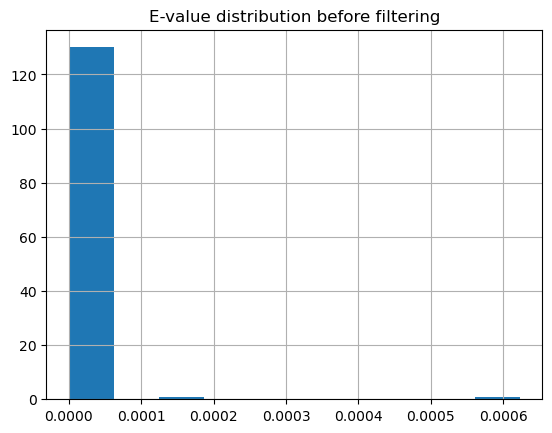

In [48]:
diamond.hist("e-value")
plt.title("E-value distribution before filtering")

Text(0.5, 1.0, 'E-value distribution after filtering (with threshold 0.0001)')

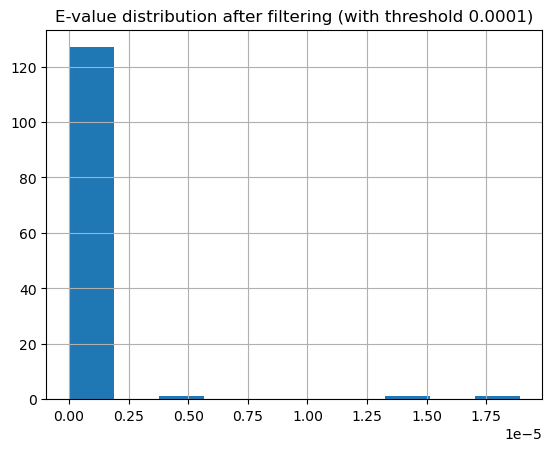

In [49]:
evalue_threshold = 0.0001
diamond = diamond.loc[diamond['e-value'] < evalue_threshold] 
diamond.hist("e-value")
plt.title(f"E-value distribution after filtering (with threshold {evalue_threshold})")


Now, we will sort rows per e-value and score and get the most significant hit per each ContigId.

Text(0.5, 1.0, 'Number of hits per contig before preprocessing')

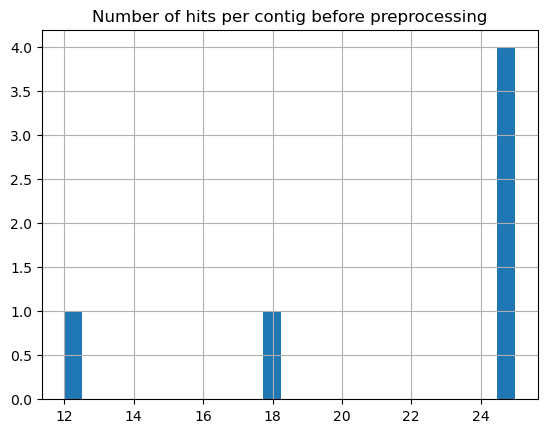

In [50]:
diamond.pivot_table(columns=['Query_id'], aggfunc='size').hist(bins = 25)
plt.title("Number of hits per contig before preprocessing")


Number of rows. Before: 1560. After: 66


Text(0.5, 1.0, 'Number of hits per contig after preprocessing')

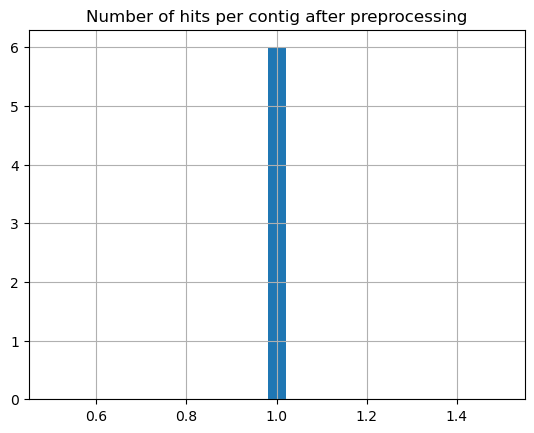

In [51]:
before = diamond.size
diamond = diamond.sort_values(
        by=['e-value', 'score'], ascending=[True, False]
        ).drop_duplicates(
    'Query_id', keep='first'
).set_index('Query_id')
after = diamond.size

print(f"Number of rows. Before: {before}. After: {after}")

diamond.pivot_table(columns=['Query_id'], aggfunc='size').hist(bins = 25)
plt.title("Number of hits per contig after preprocessing")

#####  Inspect % identity and aligment length

Text(0.5, 1.0, 'Alignment length distribution after preprocessing')

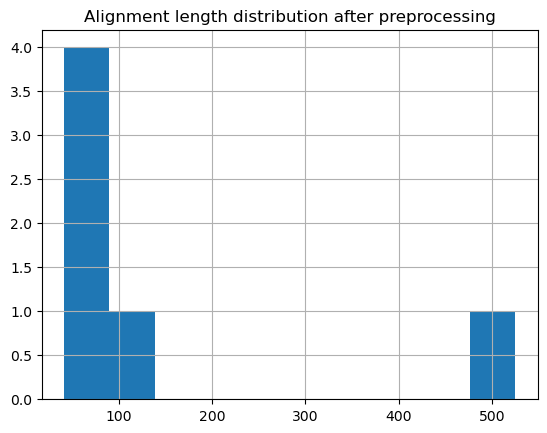

In [52]:
diamond.hist("alignment_length")
plt.title("Alignment length distribution after preprocessing")


Text(0, 0.5, 'Mistmatches')

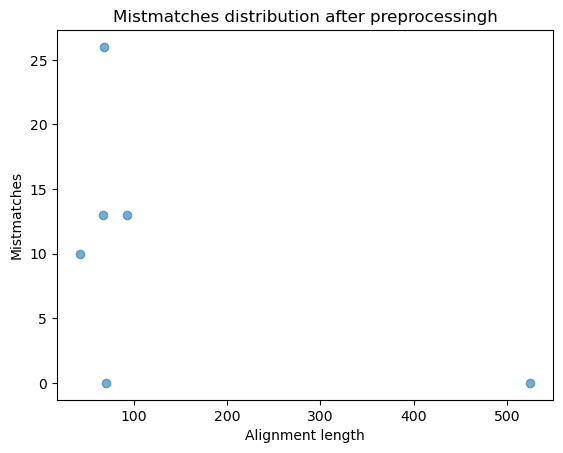

In [53]:
plt.scatter(diamond.alignment_length,diamond.mismatches,alpha=0.6)
plt.title('Mistmatches distribution after preprocessingh')
plt.xlabel('Alignment length')
plt.ylabel('Mistmatches')

Text(0.5, 1.0, 'Percentage of identity distribution after preprocessing')

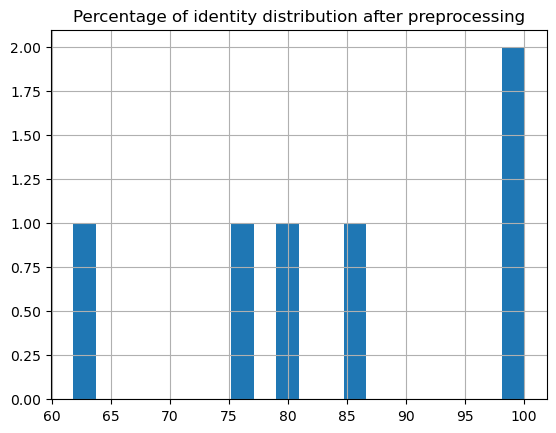

In [54]:
diamond.hist("%_identity", bins = 20)
plt.title("Percentage of identity distribution after preprocessing")


You may want to filter by % identity (for example, keep everything above 50%). 

##### Link information form diamond matches and count table
First, we are going to drop all columns except for ContigsID and orthologous genes header

In [55]:
map_table = diamond[["Subject_id"]]
map_table

,Subject_id
Query_id,
TRINITY_DN226477_c0_g1_i1,NZ_CP027579_1_4510__RS_GCF_003018335_1
TRINITY_DN226455_c0_g1_i1,MKWE01000003_1_73__GB_GCA_001899585_1
TRINITY_DN226500_c0_g1_i1,NZ_LT934425_1_2685__RS_GCF_900232105_1
TRINITY_DN226457_c0_g1_i1,NZZG01000135_1_4__GB_GCA_002698575_1
TRINITY_DN226454_c0_g1_i1,NZ_SDKM01000083_1_4__RS_GCF_004519545_1
TRINITY_DN226510_c0_g1_i1,VBIU01000006_1_34__GB_GCA_005880945_1


Now, we will merge both files by their column in common (ContigID and Subject id).

In [56]:
df = pd.merge(map_table, counts, left_index=True, right_index=True).reset_index(drop=True)
df


,Subject_id,SampleA,SampleB,SampleC,SampleD,SampleE
0,NZ_CP027579_1_4510__RS_GCF_003018335_1,0,0,0,0,0
1,MKWE01000003_1_73__GB_GCA_001899585_1,0,2,0,0,2
2,NZ_LT934425_1_2685__RS_GCF_900232105_1,0,0,2,1,0
3,NZZG01000135_1_4__GB_GCA_002698575_1,3,6,0,0,0
4,NZ_SDKM01000083_1_4__RS_GCF_004519545_1,0,0,0,9,0
5,VBIU01000006_1_34__GB_GCA_005880945_1,1,0,0,0,5


##### Aggregate table
Now, we are going to aggregate the rows by grouping them by "Subject id" (notice the difference in rows between the previous table and the following):

In [57]:
df = df.groupby('Subject_id').sum(numeric_only = True)
df


,SampleA,SampleB,SampleC,SampleD,SampleE
Subject_id,,,,,
MKWE01000003_1_73__GB_GCA_001899585_1,0,2,0,0,2
NZZG01000135_1_4__GB_GCA_002698575_1,3,6,0,0,0
NZ_CP027579_1_4510__RS_GCF_003018335_1,0,0,0,0,0
NZ_LT934425_1_2685__RS_GCF_900232105_1,0,0,2,1,0
NZ_SDKM01000083_1_4__RS_GCF_004519545_1,0,0,0,9,0
VBIU01000006_1_34__GB_GCA_005880945_1,1,0,0,0,5


##### Annotating the OTU
Now, we have to annotate the previous table. 

We will use the SQLite file of AnnoTree. You can safely ignore this next chunk if you are still getting familiar with SQL. 

We are annotating only with the NCBI tax id and the KEGG and Interpro Identifier.

In [58]:
conn = sqlite3.connect(mapping_db)
VALID_COLUMNS = ('Accession', 'Taxonomy', 'GTDB', 'EGGNOG', 'INTERPRO2GO','SEED', 'EC', 'KEGG', 'PFAM', 'TIGRFAM')
MapColumn = Enum('MapColumn', [(a, a) for a in VALID_COLUMNS], type=str)

def get_column(conn: sqlite3.Connection, column: MapColumn, acc: str)-> int:
    with closing(conn.cursor()) as cursor:
        cursor.execute(f"SELECT {column.value} FROM mappings WHERE Accession = ?", (acc,))
        return cursor.fetchone()[0]

def get_NCBI_taxonomy(conn: sqlite3.Connection, acc: str)-> int:
    return get_column(conn, MapColumn.Taxonomy, acc)

def get_KEGG_KO(conn: sqlite3.Connection, acc: str)-> int:
    val = get_column(conn, MapColumn.KEGG, acc)
    if val:
        return f"K{str(val).zfill(5)}"
    return ""

def get_INTERPRO2GO(conn: sqlite3.Connection, acc: str) -> int:
    val = get_column(conn, MapColumn.INTERPRO2GO, acc)
    if val:
        return f"IPR{str(val).zfill(6)}"
    return ""    

Now we add new columns:

In [59]:
df['NCBI_TaxID'] = [get_NCBI_taxonomy(conn, acc) for acc in df.index]
df['KEGG'] = [get_KEGG_KO(conn, acc) for acc in df.index]
df['INTERPRO2GO'] = [get_INTERPRO2GO(conn, acc) for acc in df.index]
df

,SampleA,SampleB,SampleC,SampleD,SampleE,NCBI_TaxID,KEGG,INTERPRO2GO
Subject_id,,,,,,,,
MKWE01000003_1_73__GB_GCA_001899585_1,0,2,0,0,2,1895826,K04088,
NZZG01000135_1_4__GB_GCA_002698575_1,3,6,0,0,0,51662,K13955,
NZ_CP027579_1_4510__RS_GCF_003018335_1,0,0,0,0,0,562,K01951,IPR022955
NZ_LT934425_1_2685__RS_GCF_900232105_1,0,0,2,1,0,174633,K20934,
NZ_SDKM01000083_1_4__RS_GCF_004519545_1,0,0,0,9,0,2497878,,
VBIU01000006_1_34__GB_GCA_005880945_1,1,0,0,0,5,2026724,K02033,


#### Taxonomic annotation of mRNA

Most AnnoTree entries have a NCBI taxonomy identifier (except those with NCBI_TaxID == 0). However, keep in mind that we are using mRNA and that, while a relatively high % identity might be enough to annotate a protein, it might not be enough asign a taxonomic identifier. For that case, using MEGAN can be a better option. 

We are going to be conservative, exclude entries with low % of identity and create an abundance table with the taxonomic annotation. It's interesting to know from which organisms we are "taking" the functional annotations. Is there any overrepresented specie?

In [60]:
taxa_tbl = diamond[diamond['%_identity'] >= 99]["Subject_id"]
taxa_df = pd.merge(taxa_tbl, counts, left_index=True, right_index=True).reset_index(drop=True).groupby('Subject_id').sum(numeric_only = True)
taxa_df['NCBI_TaxID'] = [get_NCBI_taxonomy(conn, acc) for acc in taxa_df.index]
taxa_df

,SampleA,SampleB,SampleC,SampleD,SampleE,NCBI_TaxID
Subject_id,,,,,,
NZ_CP027579_1_4510__RS_GCF_003018335_1,0,0,0,0,0,562
NZ_LT934425_1_2685__RS_GCF_900232105_1,0,0,2,1,0,174633


You can search the corresponding taxa using NCBI. For example, let's check the first five more abundant OTU:

In [61]:
for tax in taxa_df['NCBI_TaxID'].value_counts().index[:5]:
    print(f"https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id={tax}")


https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=562
https://www.ncbi.nlm.nih.gov/Taxonomy/Browser/wwwtax.cgi?id=174633


For example, if you suspect you have mRNA from the host, you can check the number of entries from the host. Let's check number of entries from human (it should be zero, because it's not included in AnnoTree database). 

In [62]:
HUMAN_TAXID = 9606
sum(taxa_df['NCBI_TaxID'] == HUMAN_TAXID)

0

Finally, we are going to add different taxonomic ranks. First, we define a few functions. 

In [63]:
from ete3 import NCBITaxa
ncbi = NCBITaxa()

def get_lineage(taxid):
    """Get dictionary with rank as keys and name as values
    >>> get_lineage(49992).get('species')
    'Thymus vulgaris'
    >>> get_lineage(2)
    {'no rank': 'cellular organisms', 'superkingdom': 'Bacteria'}
    >>> get_lineage(0)
    {}
    """
    if taxid <= 0:
        return {}
    try:
        lineage = ncbi.get_lineage(taxid)
        ranks = ncbi.get_rank(lineage)
        names = ncbi.translate_to_names(lineage)
        return {ranks[k]: elm for k, elm  in zip(lineage, names)}
    except ValueError:
        return {}
def get_taxonomy_row(taxid):
    """
    Parse taxa into greengenes-like format
    >>> get_taxonomy_row(49992)
    'k__Viridiplantae;p__Streptophyta;c__Magnoliopsida;o__Lamiales;f__Lamiaceae;g__Thymus;s__Thymus vulgaris'
    """
    lineage = get_lineage(taxid)
    ranks = {
        'kingdom': 'k__', 'phylum':'p__', 'class': 'c__',
        'order':'o__', 'family':'f__', 'genus':'g__', 'species':'s__'
        }
    for rank in ranks:
        ranks[rank] += lineage.get(rank, '')
    return ";".join(ranks.values())

def get_taxonomy_row2(taxid):
    """
    Parse taxa separated with semicolon
    >>> get_taxonomy_row2(49992)
    'Viridiplantae;Streptophyta;Magnoliopsida;Lamiales;Lamiaceae;Thymus;Thymus vulgaris'
    """
    lineage = get_lineage(taxid)
    ranks = {rank:'' for rank in (
        'kingdom', 'phylum', 'class', 'order', 'family', 'genus', 'species'
    )}        
    for rank in ranks:
        ranks[rank] += lineage.get(rank, 'X')
    return ";".join(ranks.values())
import doctest
doctest.testmod()


TestResults(failed=0, attempted=5)

In [64]:
#[get_taxonomy_row(taxid) for taxid in taxa_df['NCBI_TaxID'][1:5]]
taxa_df = taxa_df.reset_index(drop=True).groupby('NCBI_TaxID').sum(numeric_only = True)
taxa_df['Taxonomy'] = [get_taxonomy_row(int(taxid)) for taxid in taxa_df.index]
taxa_df

,SampleA,SampleB,SampleC,SampleD,SampleE,Taxonomy
NCBI_TaxID,,,,,,
562,0,0,0,0,0,k__;p__Pseudomonadota;c__Gammaproteobacteria;o...
174633,0,0,2,1,0,k__;p__Planctomycetota;c__Candidatus Brocadiia...


In [65]:
taxa_df.to_csv(snakemake.output.taxonomy, sep='\t', index=False)

### Functional annotation

Now, we are going to annotate the OTU with the KEGG and Interpro identifiers. Let's check how many non-annotated entries do we have:

In [66]:
print(f"There are {df.shape[0]} rows in the dataframe")
print(f"There are {(df['KEGG'] == '').sum()} rows with no KEGG identifier")
print(f"There are {(df['INTERPRO2GO'] == '').sum()} rows with no INTERPRO2GO identifier")


There are 6 rows in the dataframe
There are 1 rows with no KEGG identifier
There are 5 rows with no INTERPRO2GO identifier


##### Adding BRITE high-level annotations
Now, we can use KEGG BRITE to add high-level annotations to this table. It's not pretty code, but it works:



In [67]:
import json
with open(brite_json, 'r') as json_file:
    # Read the contents of the file
    json_data = json_file.read()
    # Parse the JSON data
    brite = json.loads(json_data)
def get_brite(kos, include = [], ) -> dict[str: tuple[str]]:
    annotations = dict()
    for LevelA in brite['children']:
            if LevelA['name'] not in include:
                continue
            for LevelB in LevelA.get('children', []):
                for LevelC in LevelB.get('children', []):
                    for LevelD in LevelC.get('children', []):
                        name = LevelD['name'].split()[0]
                        if name in kos:
                            description = LevelD['name'].split(';')[1].strip()
                            new_annotation = (LevelA['name'], LevelB['name'], LevelC['name'], description)
                            if name in annotations:
                                annotations[name].append(new_annotation)
                            annotations[name] = [new_annotation]
    return annotations

Now, we get some annotations. We have to decide which annotations to use. Those are the ones available in the BRITE hierarchy:

In [68]:
[y['name'] for y in brite['children']]

['09100 Metabolism',
 '09120 Genetic Information Processing',
 '09130 Environmental Information Processing',
 '09140 Cellular Processes',
 '09150 Organismal Systems',
 '09160 Human Diseases',
 '09180 Brite Hierarchies',
 '09190 Not Included in Pathway or Brite']

We are going to use annotate with both Brite and Metabolism.

### Adding Brite hierarchy

In [69]:
annotations = get_brite(df.KEGG.to_list(), include = '09180 Brite Hierarchies') 

And we add them to the DataFrame

In [70]:
df['Level1'] = [",".join(x[1] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df['Level2'] = [",".join(x[2] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df['Level3'] = [",".join(x[3] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df

,SampleA,SampleB,SampleC,SampleD,SampleE,NCBI_TaxID,KEGG,INTERPRO2GO,Level1,Level2,Level3
Subject_id,,,,,,,,,,,
MKWE01000003_1_73__GB_GCA_001899585_1,0,2,0,0,2,1895826,K04088,,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],modulator of FtsH protease HflK
NZZG01000135_1_4__GB_GCA_002698575_1,3,6,0,0,0,51662,K13955,,,,
NZ_CP027579_1_4510__RS_GCF_003018335_1,0,0,0,0,0,562,K01951,IPR022955,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]
NZ_LT934425_1_2685__RS_GCF_900232105_1,0,0,2,1,0,174633,K20934,,,,
NZ_SDKM01000083_1_4__RS_GCF_004519545_1,0,0,0,9,0,2497878,,,,,
VBIU01000006_1_34__GB_GCA_005880945_1,1,0,0,0,5,2026724,K02033,,09183 Protein families: signaling and cellular...,02000 Transporters [BR:ko02000],peptide/nickel transport system permease protein


Let's show a few annotated rows: 

In [71]:
df[df['Level1'] != '']

,SampleA,SampleB,SampleC,SampleD,SampleE,NCBI_TaxID,KEGG,INTERPRO2GO,Level1,Level2,Level3
Subject_id,,,,,,,,,,,
MKWE01000003_1_73__GB_GCA_001899585_1,0,2,0,0,2,1895826,K04088,,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],modulator of FtsH protease HflK
NZ_CP027579_1_4510__RS_GCF_003018335_1,0,0,0,0,0,562,K01951,IPR022955,09181 Protein families: metabolism,01002 Peptidases and inhibitors [BR:ko01002],GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]
VBIU01000006_1_34__GB_GCA_005880945_1,1,0,0,0,5,2026724,K02033,,09183 Protein families: signaling and cellular...,02000 Transporters [BR:ko02000],peptide/nickel transport system permease protein


In [72]:
df.index.name = 'ContigID'
df.to_csv(snakemake.output.brite_ann, sep='\t')

### Adding KEGG metabolism

In [73]:
annotations = get_brite(df.KEGG.to_list(), include = '09100 Metabolism') 

In [74]:
df['Level1'] = [",".join(x[1] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df['Level2'] = [",".join(x[2] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df['Level3'] = [",".join(x[3] for x in annotations[ko]) if ko in annotations else '' for ko in df.KEGG.to_list()]
df

,SampleA,SampleB,SampleC,SampleD,SampleE,NCBI_TaxID,KEGG,INTERPRO2GO,Level1,Level2,Level3
ContigID,,,,,,,,,,,
MKWE01000003_1_73__GB_GCA_001899585_1,0,2,0,0,2,1895826,K04088,,,,
NZZG01000135_1_4__GB_GCA_002698575_1,3,6,0,0,0,51662,K13955,,,,
NZ_CP027579_1_4510__RS_GCF_003018335_1,0,0,0,0,0,562,K01951,IPR022955,09111 Xenobiotics biodegradation and metabolism,00983 Drug metabolism - other enzymes [PATH:ko...,GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]
NZ_LT934425_1_2685__RS_GCF_900232105_1,0,0,2,1,0,174633,K20934,,09102 Energy metabolism,00910 Nitrogen metabolism [PATH:ko00910],hydrazine synthase subunit [EC:1.7.2.7]
NZ_SDKM01000083_1_4__RS_GCF_004519545_1,0,0,0,9,0,2497878,,,,,
VBIU01000006_1_34__GB_GCA_005880945_1,1,0,0,0,5,2026724,K02033,,,,


Let's show a few annotated rows: 

In [75]:
df[df['Level1'] != '']

,SampleA,SampleB,SampleC,SampleD,SampleE,NCBI_TaxID,KEGG,INTERPRO2GO,Level1,Level2,Level3
ContigID,,,,,,,,,,,
NZ_CP027579_1_4510__RS_GCF_003018335_1,0,0,0,0,0,562,K01951,IPR022955,09111 Xenobiotics biodegradation and metabolism,00983 Drug metabolism - other enzymes [PATH:ko...,GMP synthase (glutamine-hydrolysing) [EC:6.3.5.2]
NZ_LT934425_1_2685__RS_GCF_900232105_1,0,0,2,1,0,174633,K20934,,09102 Energy metabolism,00910 Nitrogen metabolism [PATH:ko00910],hydrazine synthase subunit [EC:1.7.2.7]


In [76]:
df.to_csv(snakemake.output.metabolism, sep='\t')